In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
)
from optimize import optimize_line_batch

from matplotlib import pyplot as plt
import numpy as np
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density


def get_pixel_coords_and_density(image, device=DEVICE):
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)

    torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32)).to(device)
    torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32)).to(device)

    return torch_pixel_coords, torch_pixel_density


def wrap_lines_into_numpy_batch(lines):
    for line in lines:
        line.append(0.5)
    lines = np.array([lines], dtype=np.float32)
    return lines


def torch_to_synthetic_lines(patch_lines):
    return patch_lines.numpy()[:, :5]

In [4]:
# perturber = LinePerturbationPipe(
#     LineRandomShift((-6, 6), (0, 2), 4),
#     LineClip(0, 63, 0, 63)
# )
# 
# renderer = Renderer((64, 64), dtype=torch.float32, device=DEVICE)
# 
# print('Yellow lines are perturbed/transported')
# print('Gray background lines are ground truth')
# 
# for random_seed in range(30):
#     generator = SyntheticPatch()
#     generator.random_lines(3, random_seed=random_seed)
#     
#     perturbed_lines = perturber.transform(generator.get_lines())
#     perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
#     
#     image = np.array(generator.get_image(), dtype=np.float32) / 255
#     raster_coords, raster_masses = get_pixel_coords_and_density(image)
#     grads = []
#     optimized, steps = optimize_line_batch(torch.from_numpy(perturbed_batch).to(DEVICE),
#                                            raster_coords, raster_masses, return_batches_by_step=True, image=image,
#                                            lr=0.1, n_iters=100, coord_only_steps=85, width_lr=0.1, ot=0., bce=1., grads=grads)
#     optimized = optimized.detach().cpu()
#     
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.title('Before')
#     plt.imshow(generator.get_image(), cmap='gray', alpha=0.6)
#     plt.imshow(SyntheticPatch.from_lines(perturbed_lines).get_image(), alpha=0.6)
#     plt.subplot(1, 3, 2)
#     plt.title('After')
#     plt.imshow(generator.get_image(), cmap='gray', alpha=0.6)
#     plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(optimized[0])).get_image(), alpha=0.6)
#     plt.subplot(1, 3, 3)
#     plt.title('L2 norm of all grads')
#     grad_norms = []
#     for grad in grads:
#         grad_norms.append(torch.sqrt((grad * grad).sum()))
#     plt.plot(grad_norms)
#     plt.show()

Yellow lines are perturbed/transported
Gray background lines are ground truth


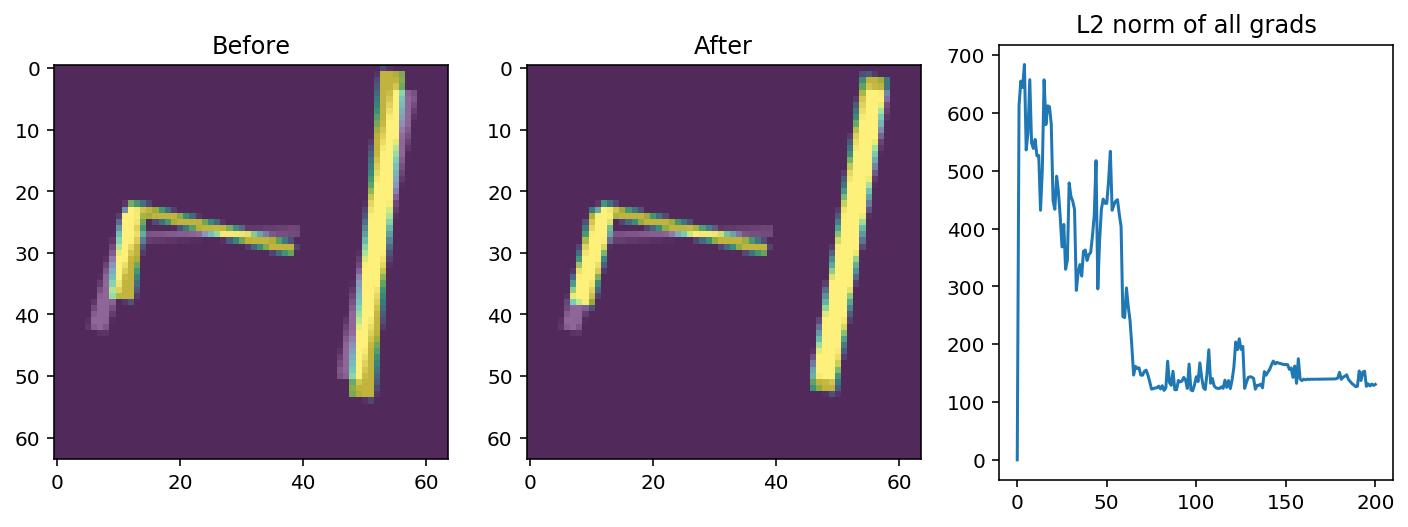

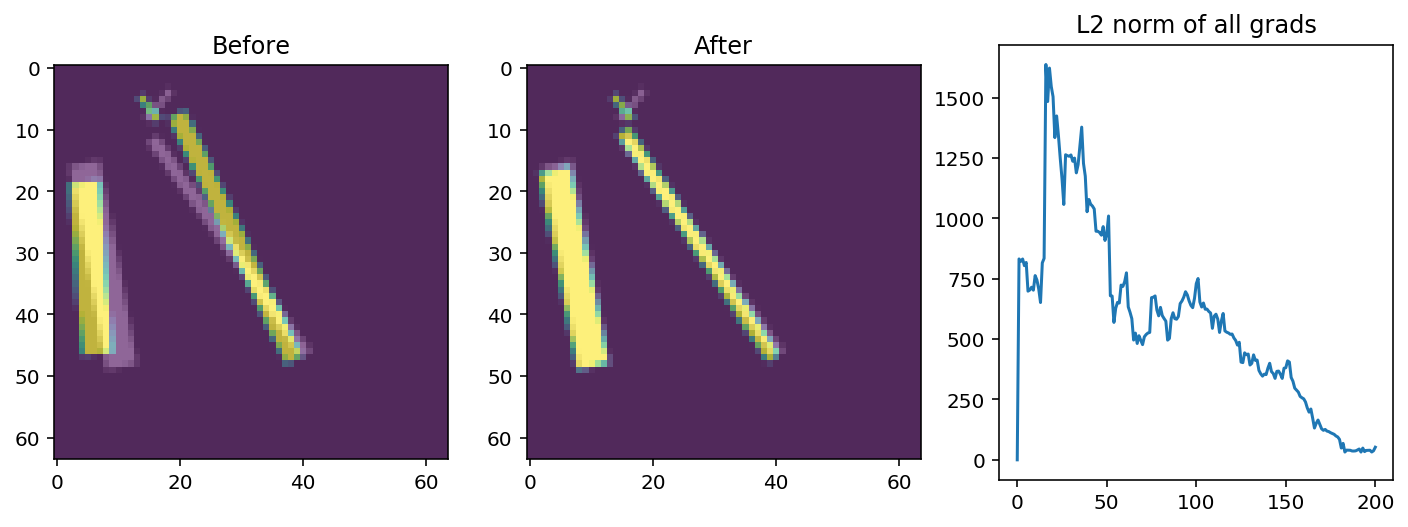

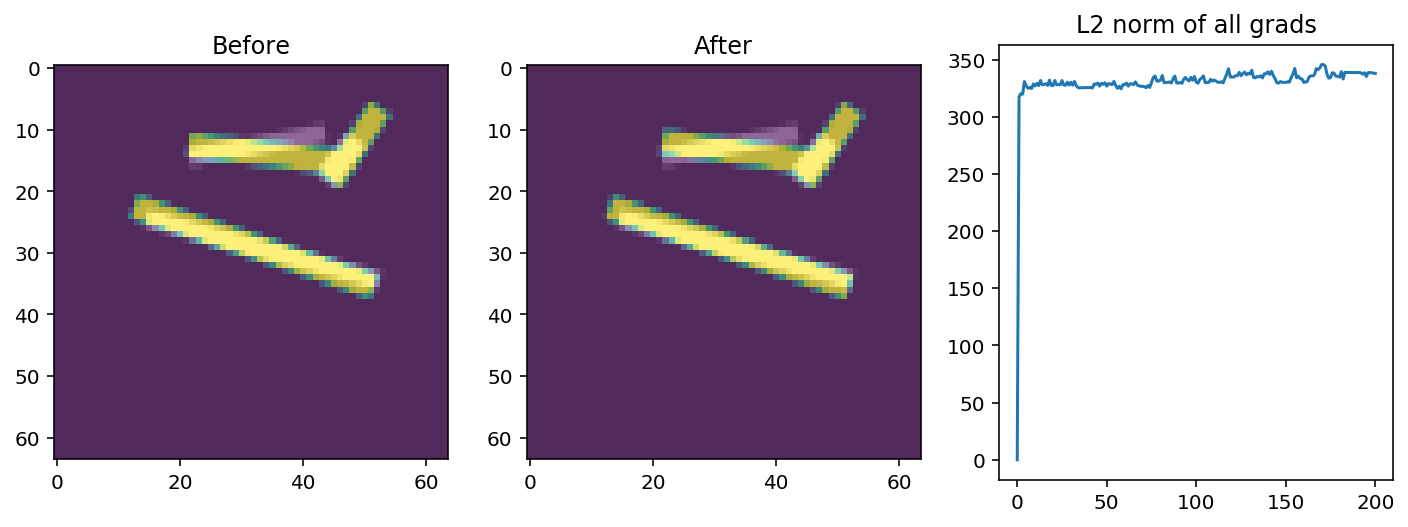

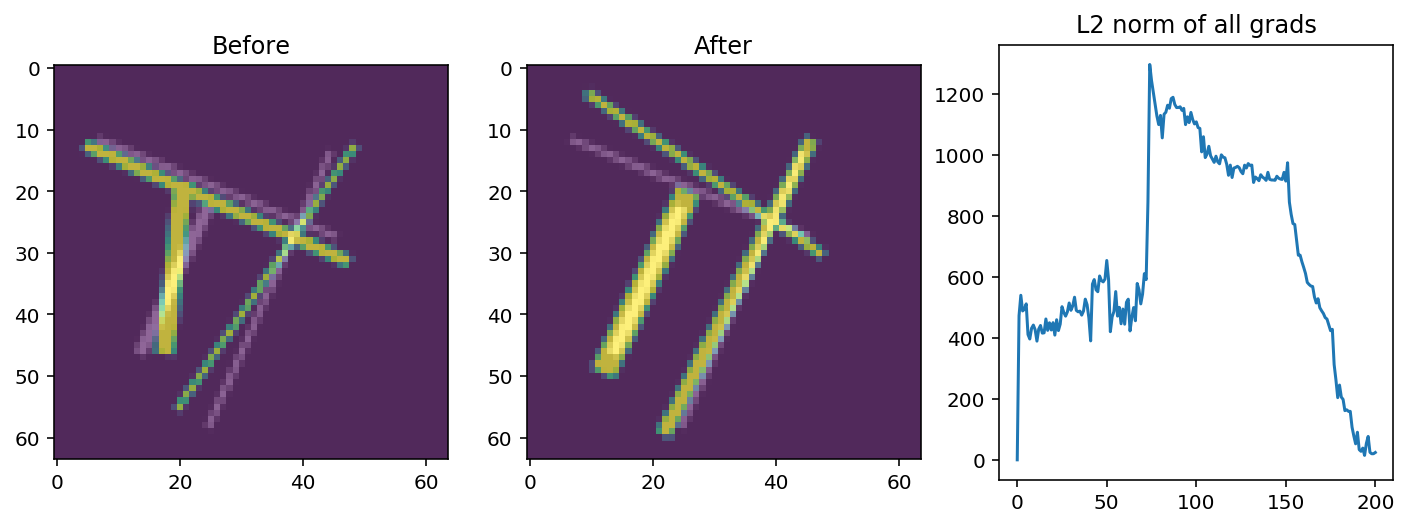

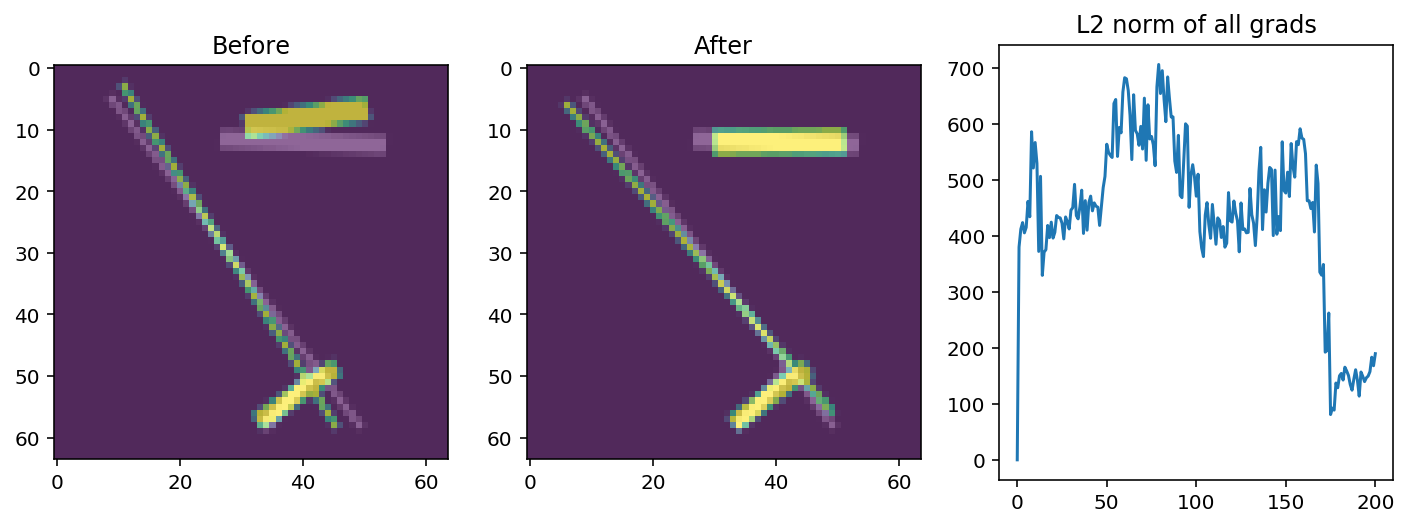

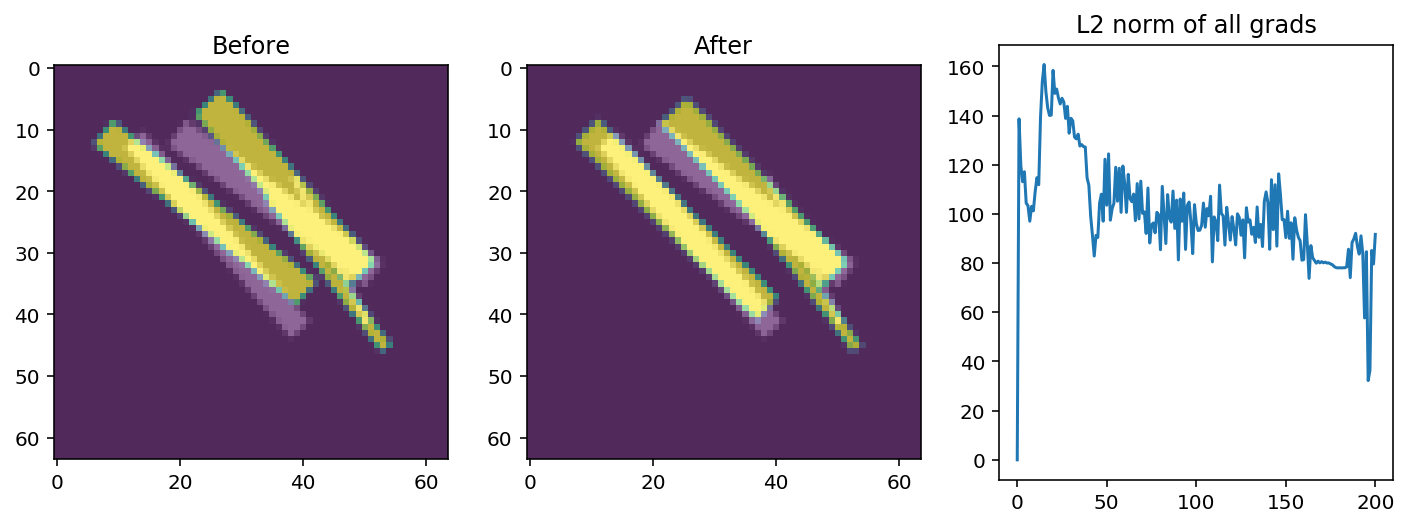

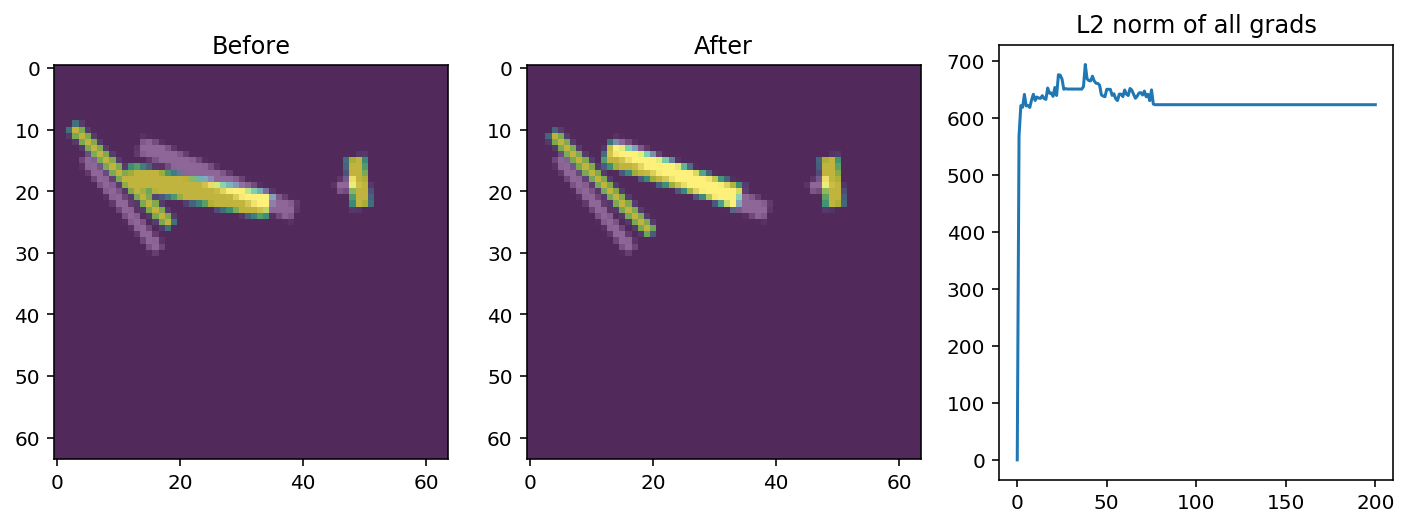

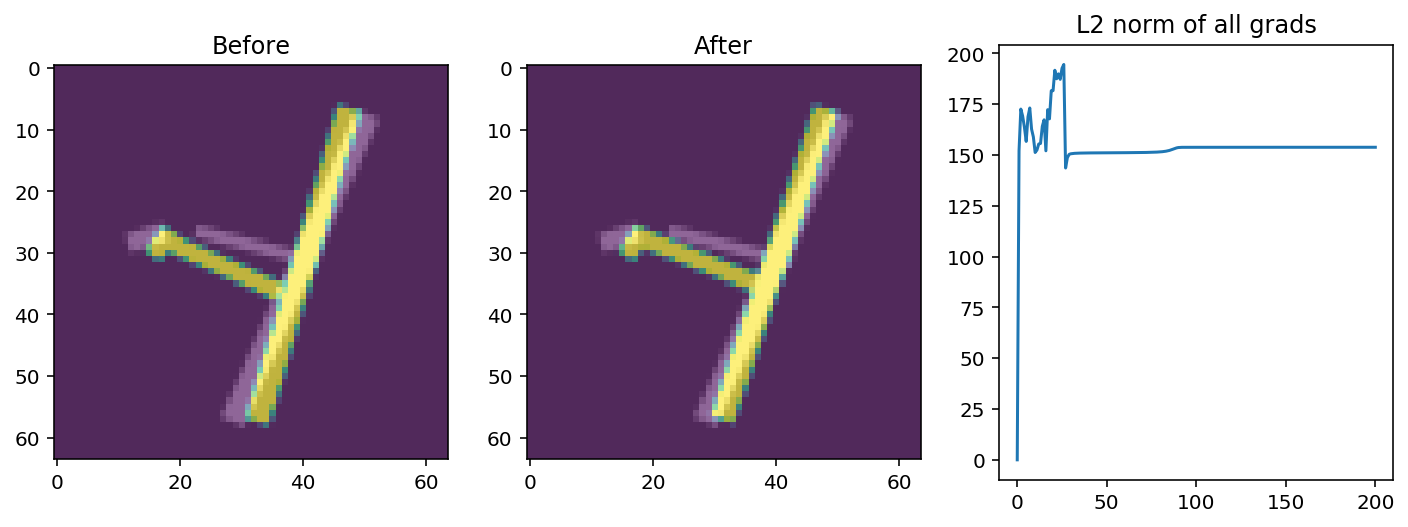

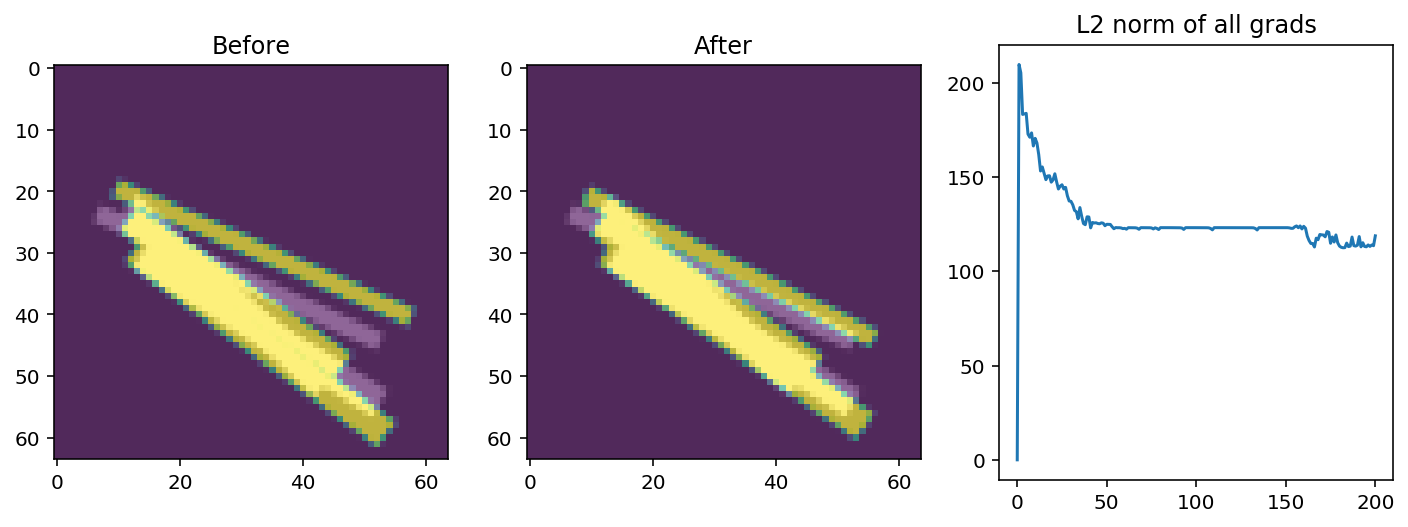

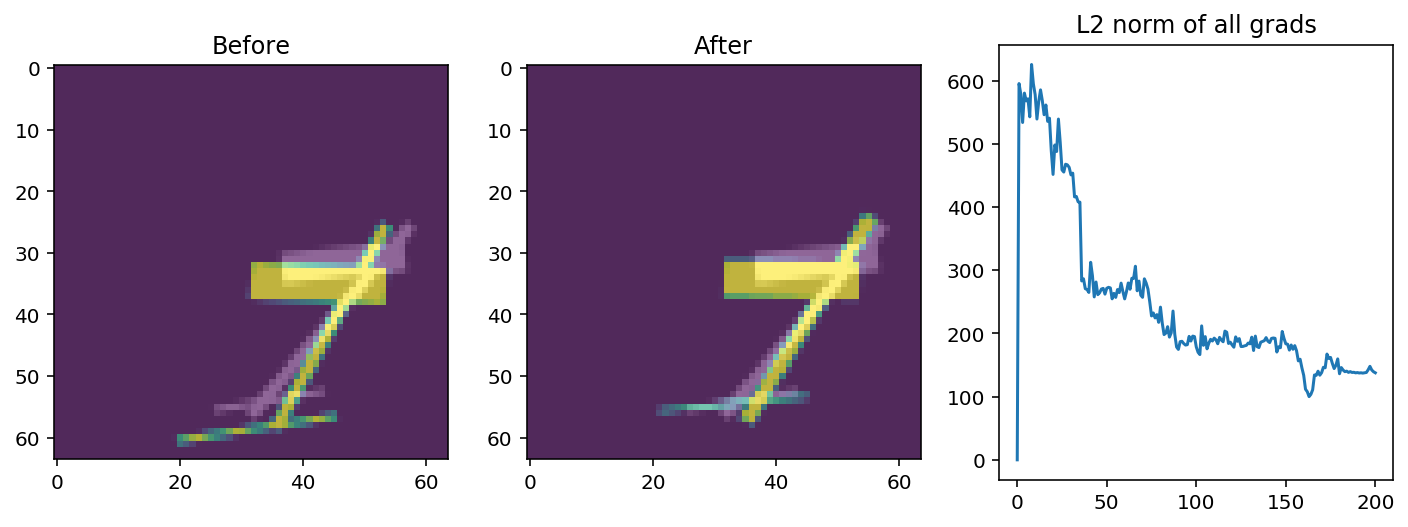

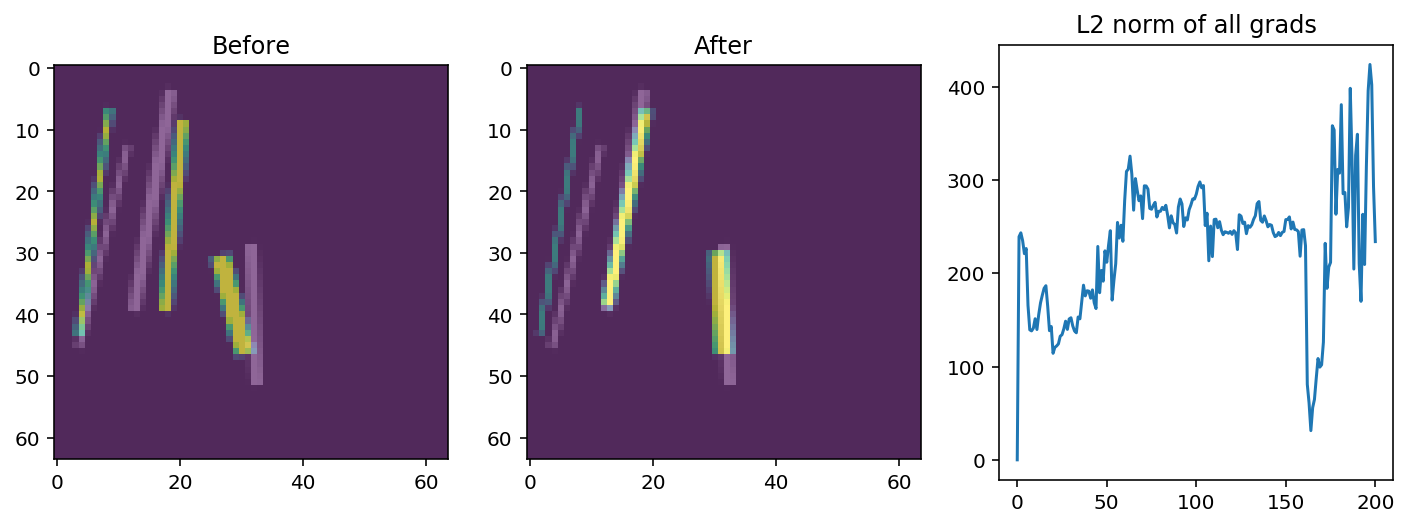

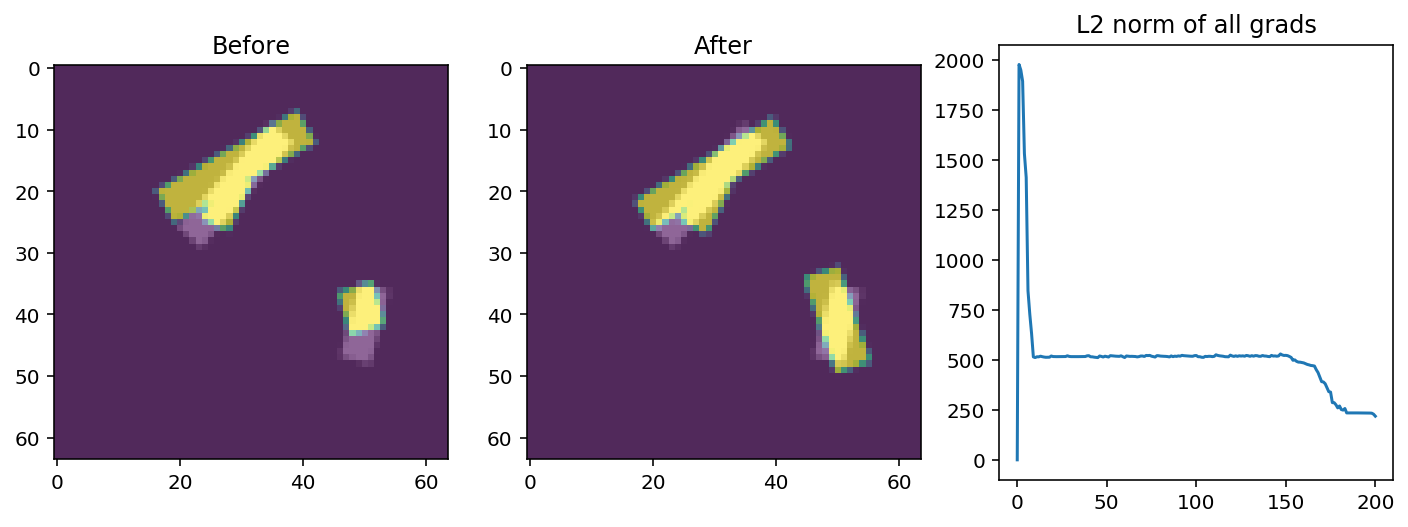

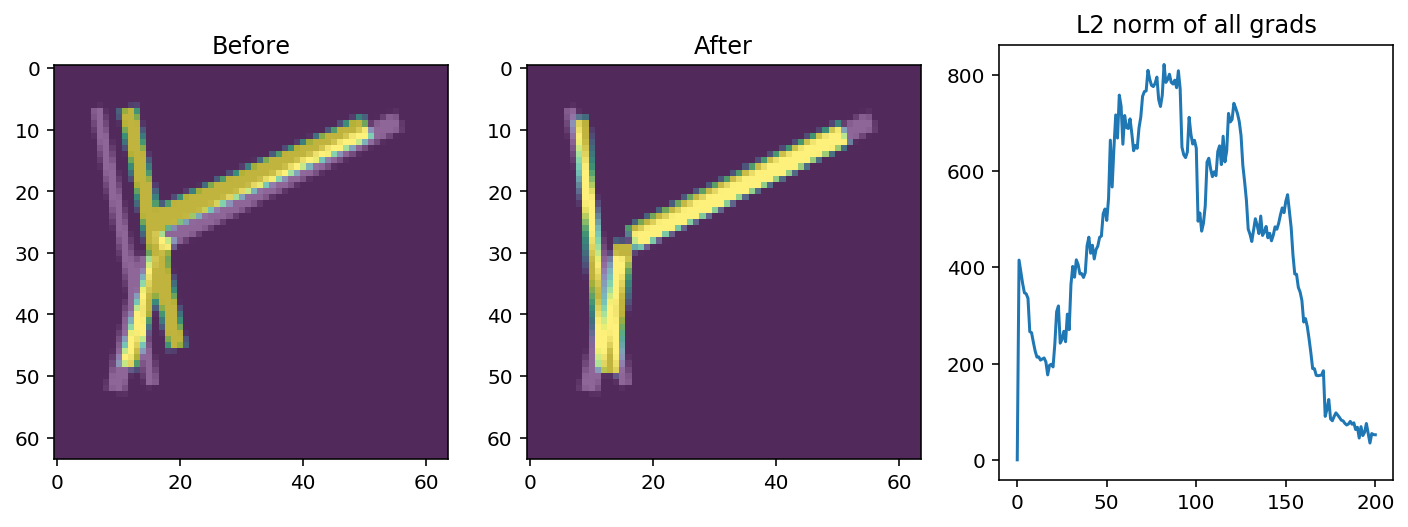

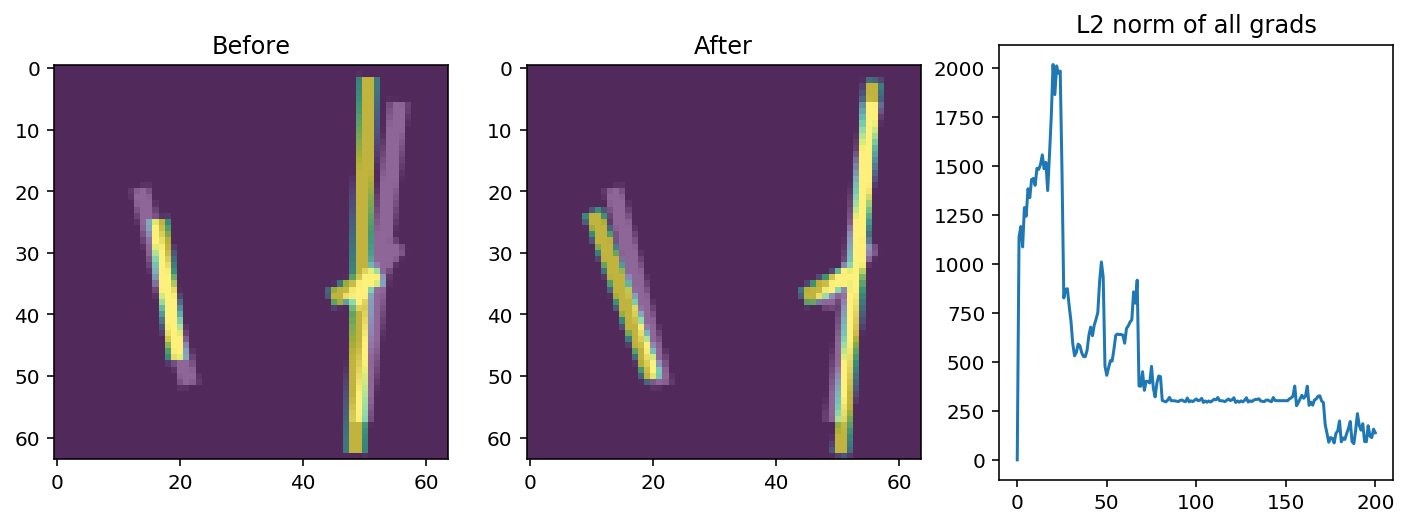

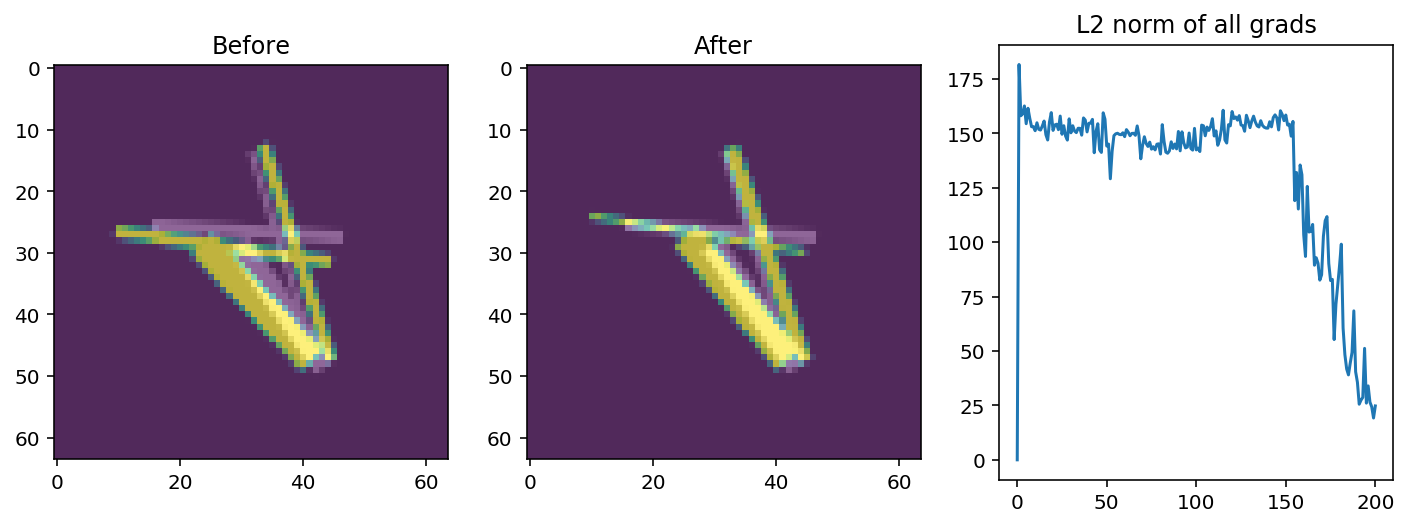

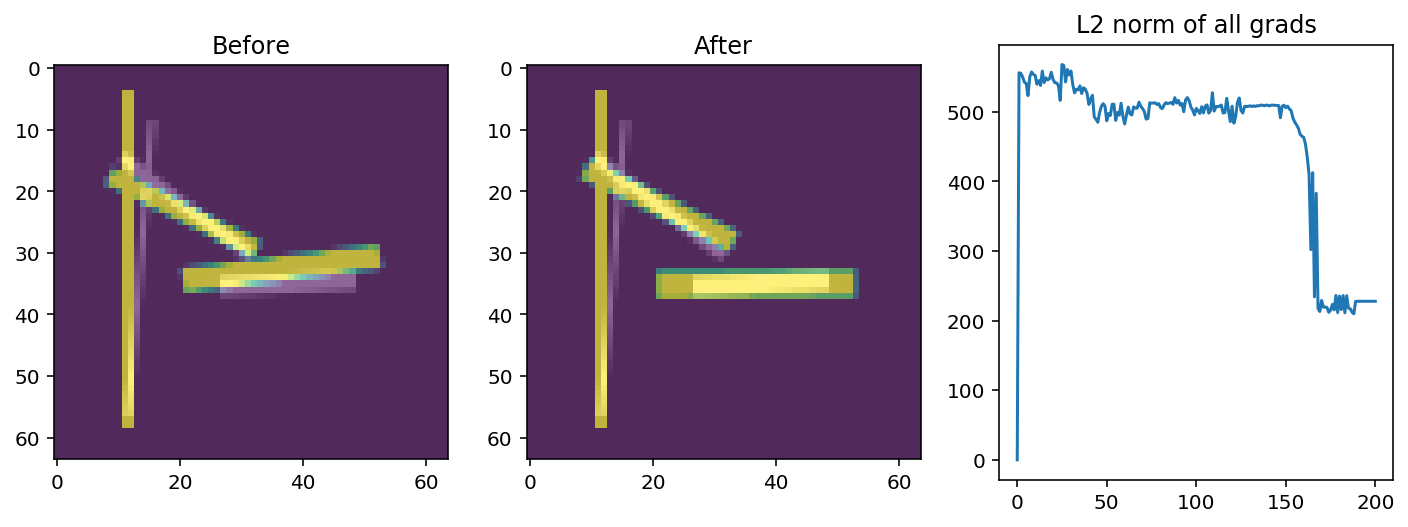

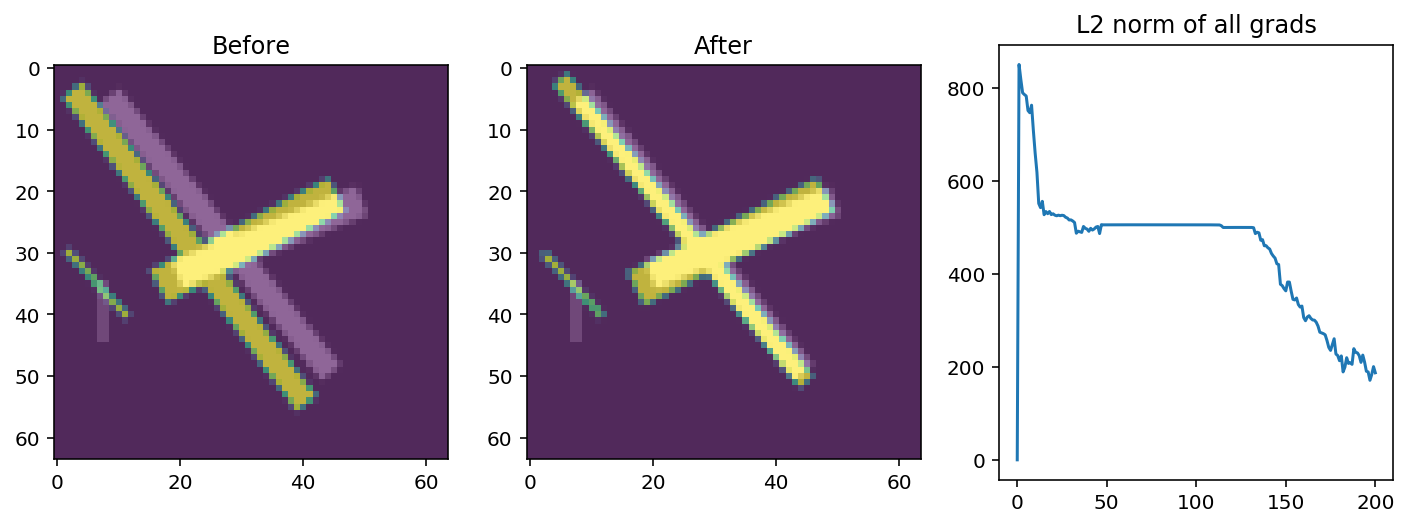

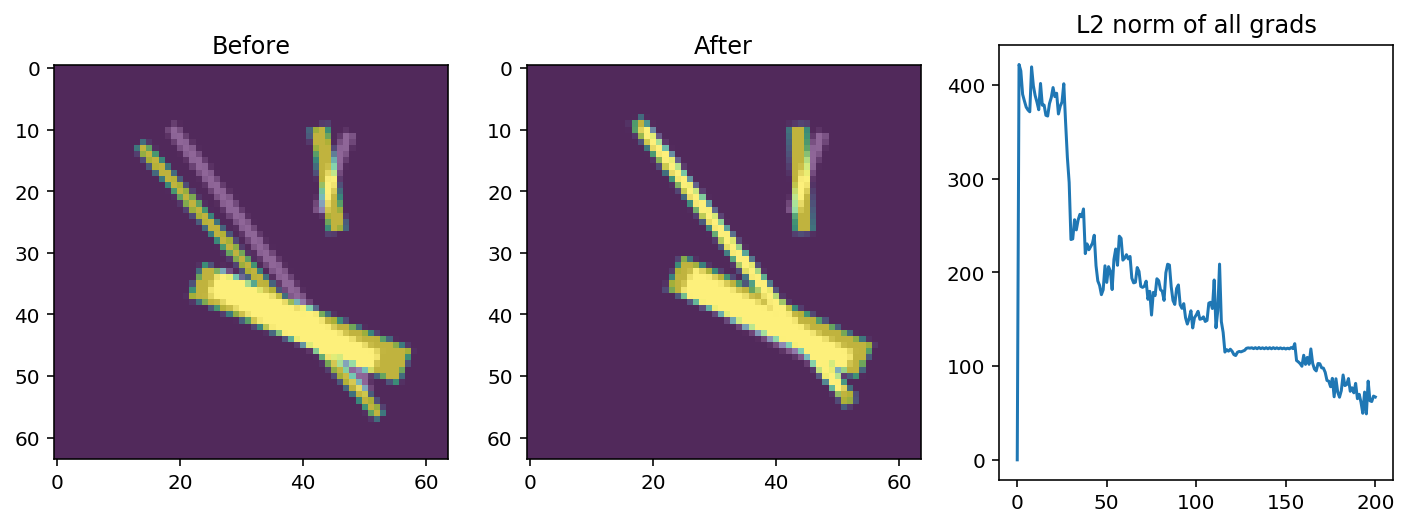

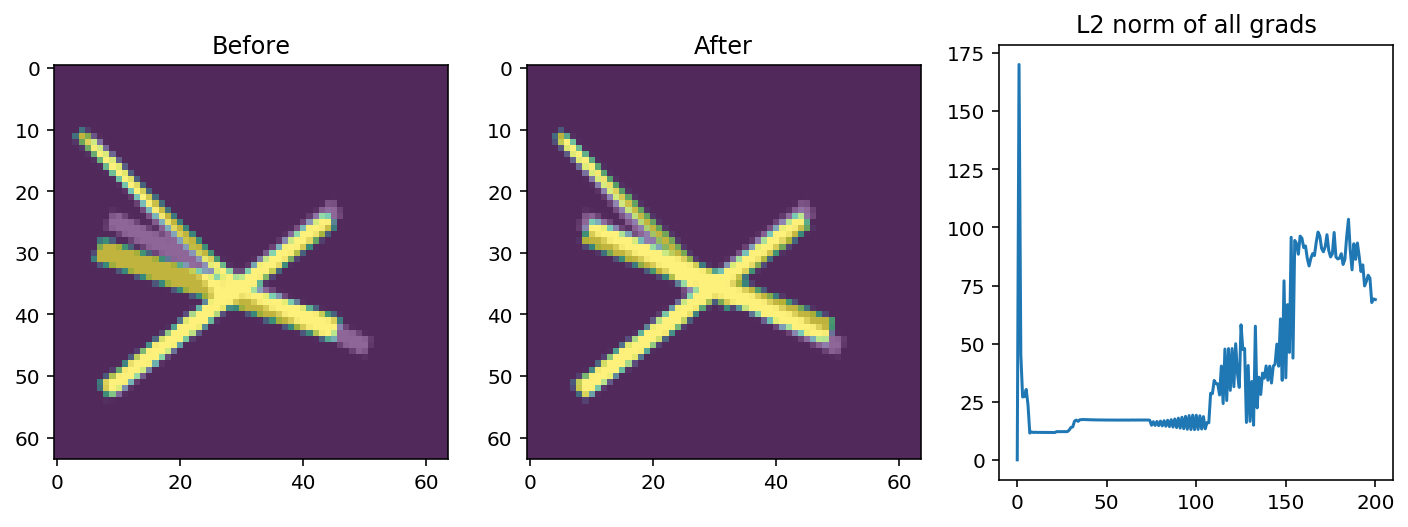

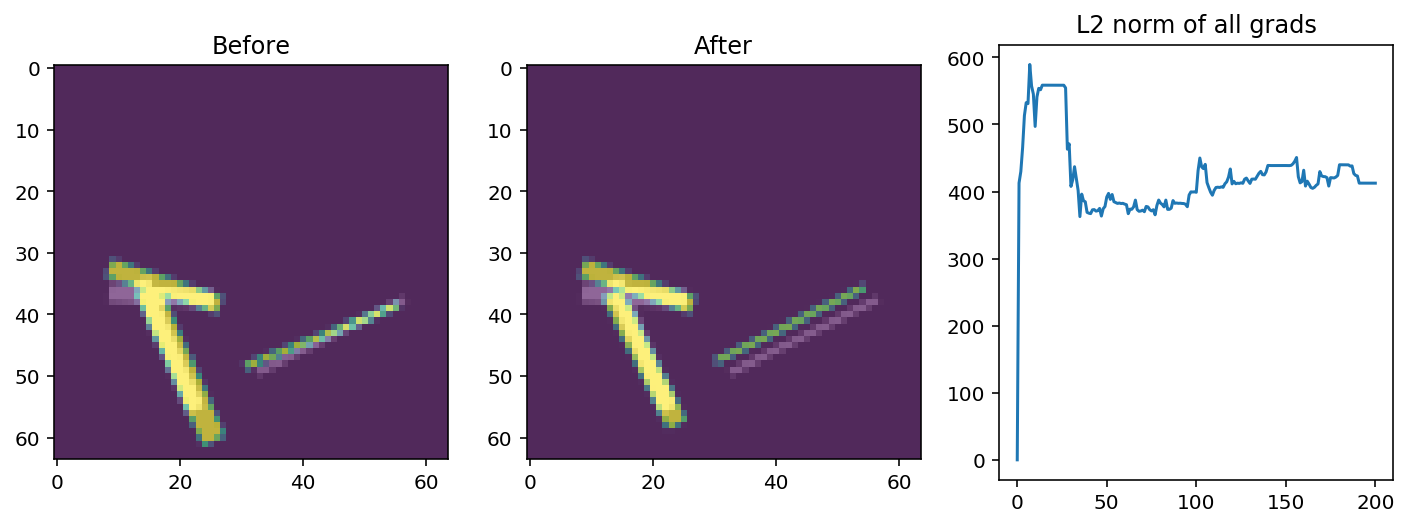

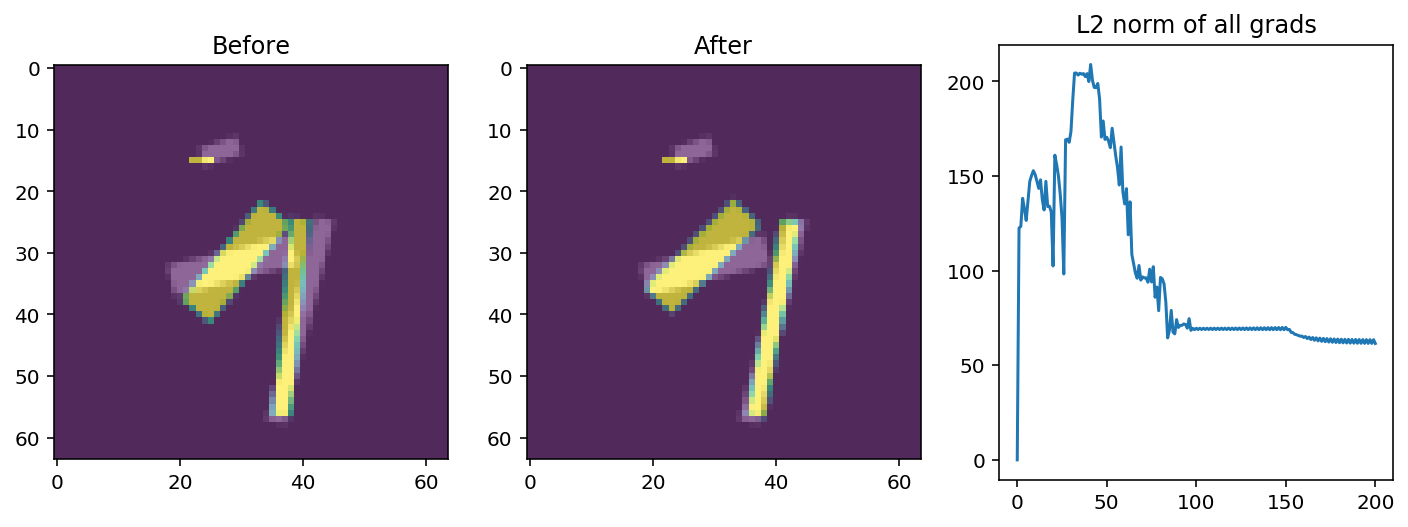

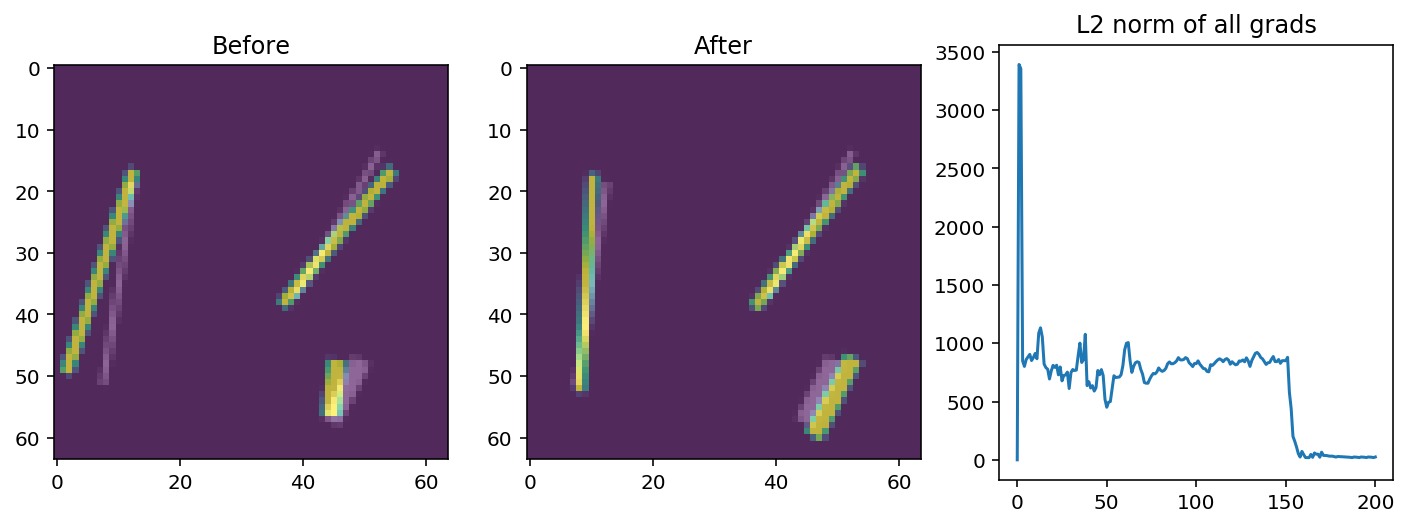

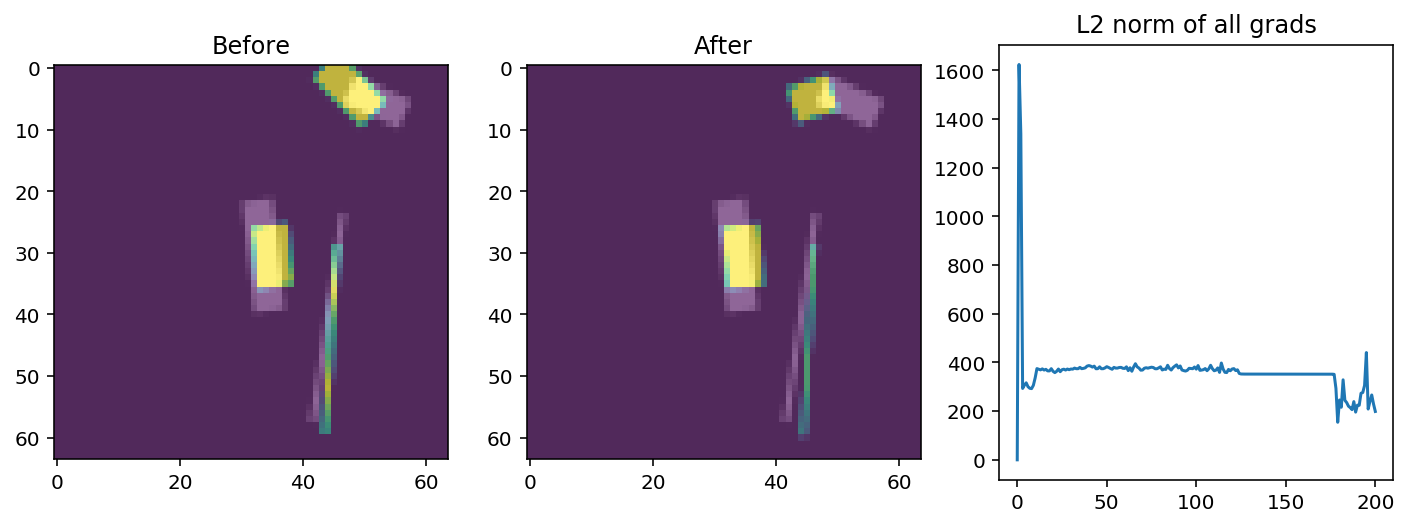

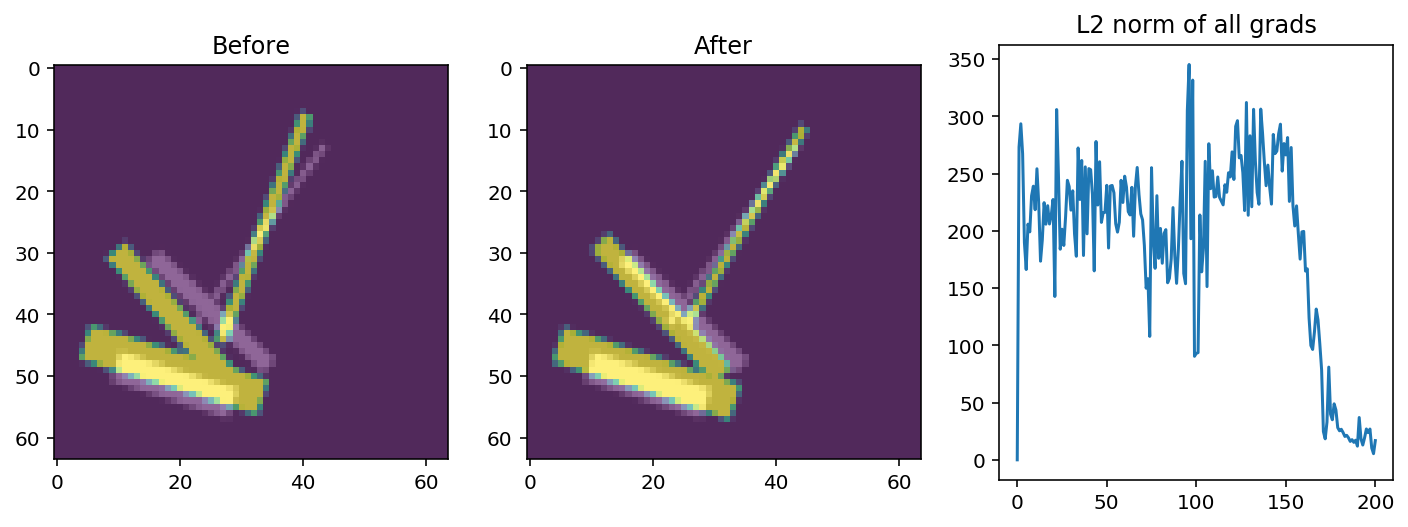

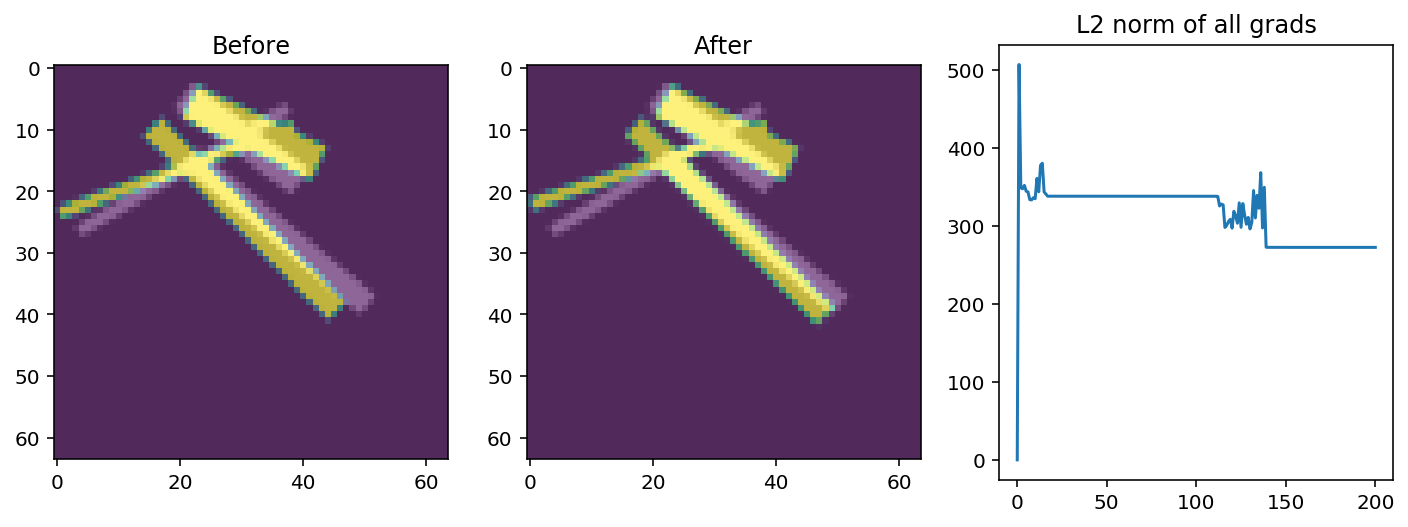

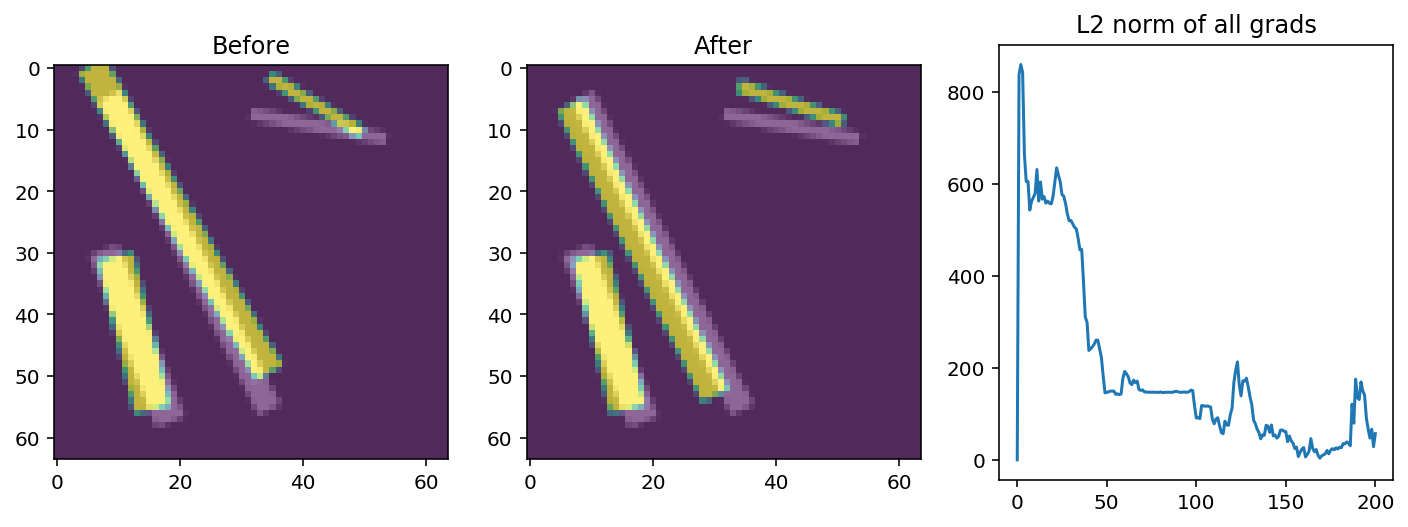

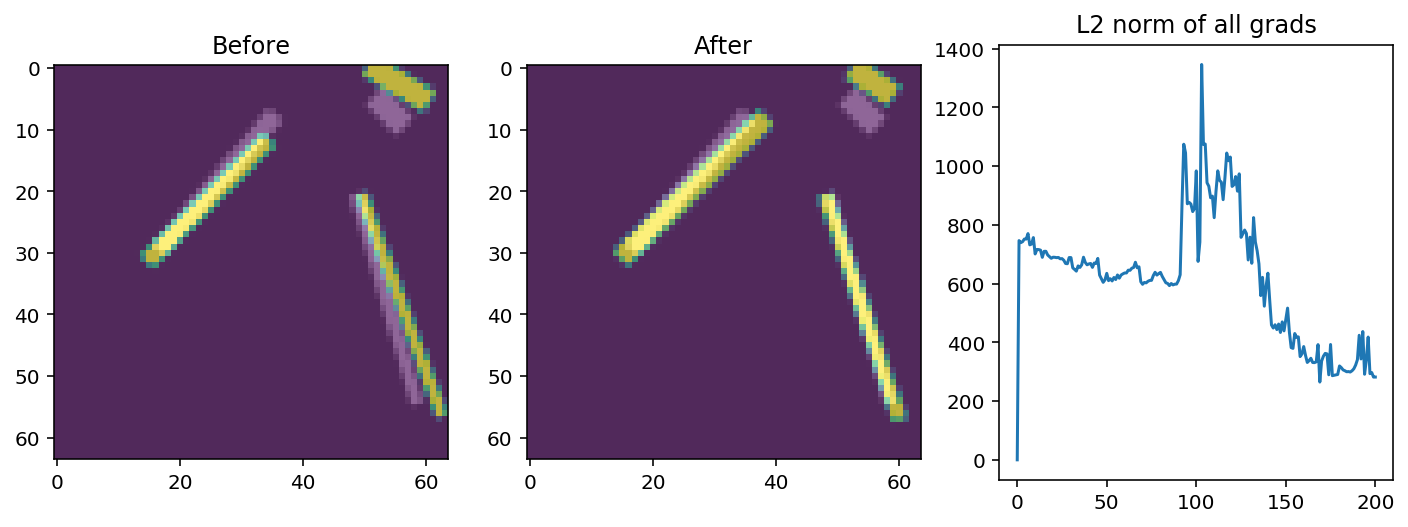

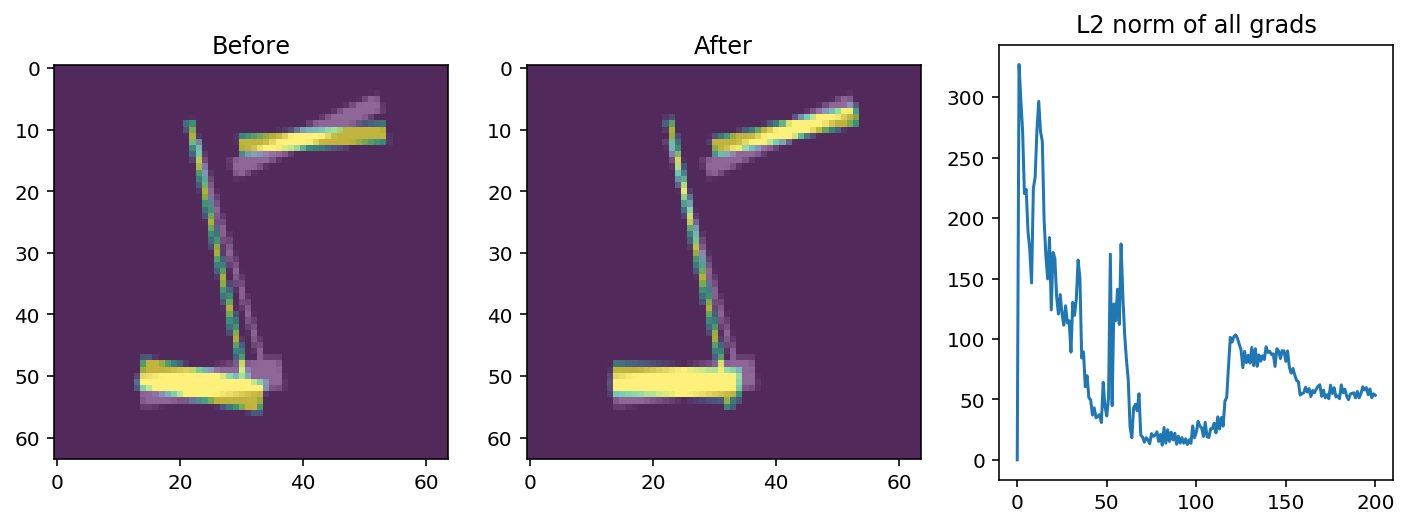

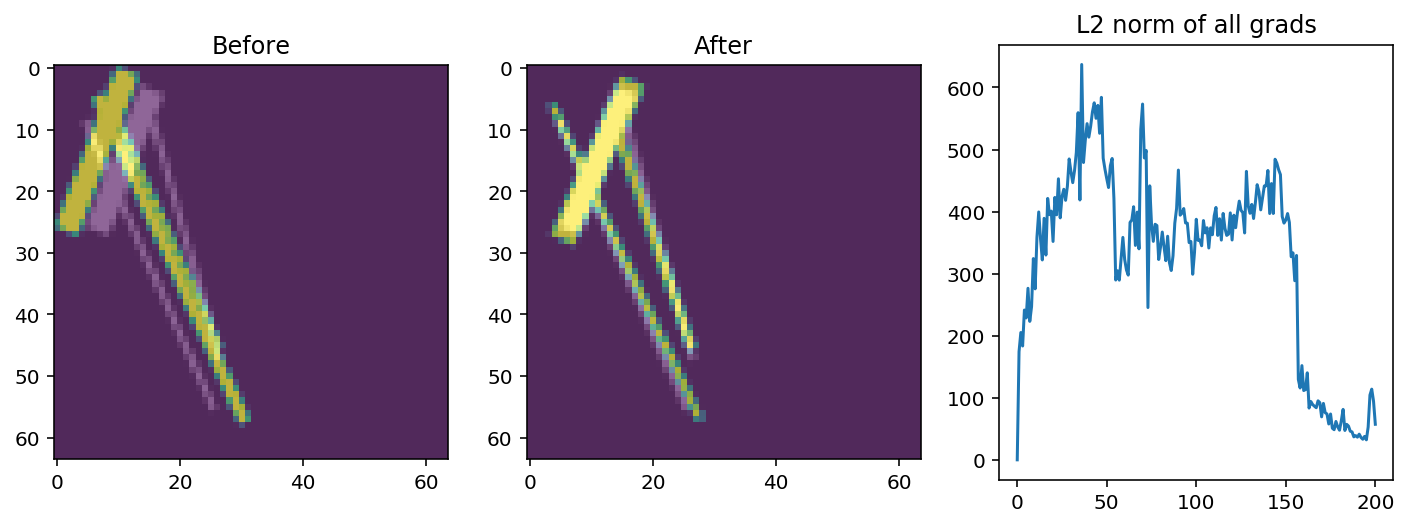

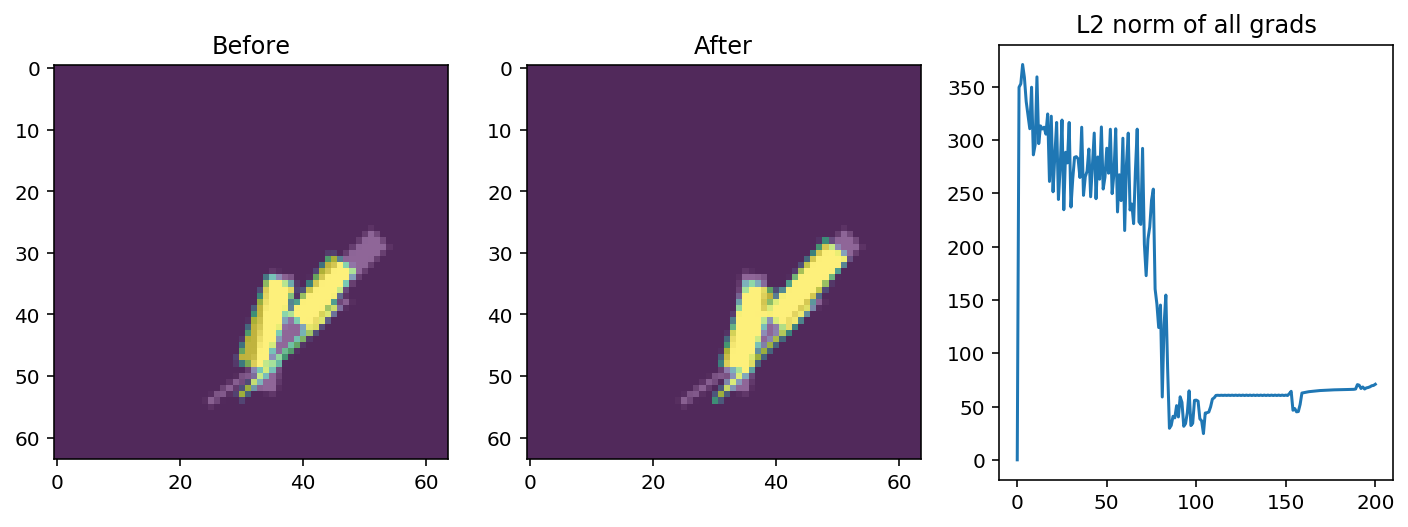

In [4]:
perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 2), 4),
    LineClip(0, 63, 0, 63)
)

renderer = Renderer((64, 64), dtype=torch.float32, device=DEVICE)

print('Yellow lines are perturbed/transported')
print('Gray background lines are ground truth')

for random_seed in range(30):
    generator = SyntheticPatch()
    generator.random_lines(3, random_seed=random_seed)
    
    perturbed_lines = perturber.transform(generator.get_lines())
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    image = np.array(generator.get_image(), dtype=np.float32) / 255
    raster_coords, raster_masses = get_pixel_coords_and_density(image)
    grads = []
    optimized, steps = optimize_line_batch(torch.from_numpy(perturbed_batch).to(DEVICE),
                                           raster_coords, raster_masses, return_batches_by_step=True, image=image,
                                           lr=0.2, n_iters=200, coord_only_steps=150, width_lr=0.1, ot=1., mse=0.5, grads=grads)
    optimized = optimized.detach().cpu()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Before')
    plt.imshow(generator.get_image(), cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(perturbed_lines).get_image(), alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('After')
    plt.imshow(generator.get_image(), cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(optimized[0])).get_image(), alpha=0.6)
    plt.subplot(1, 3, 3)
    plt.title('L2 norm of all grads')
    grad_norms = []
    for grad in grads:
        grad_norms.append(torch.sqrt((grad * grad).sum()))
    plt.plot(grad_norms)
    plt.show()
    
#     for i, step in enumerate(steps):
#         plt.figure(figsize=(6, 6))
#         plt.imshow(generator.get_image(), cmap='gray', alpha=0.6)
#         plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(step[0])).get_image(), alpha=0.6)
#         plt.savefig(f'{random_seed}/{i}.png')
#         plt.close()